Read/Tidy results from PCA-SIFT Training

In [1]:
import pickle
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
TOP_10_CATS_ID = set([1,  3, 62, 84, 44, 47, 67, 51, 10, 31])
CATS_NAMES = {
    1: 'person',
    3: 'car',
    62: 'chair',
    84: 'book',
    44: 'bottle',
    47: 'cup',
    67: 'dinning table',
    51: 'traffic light',
    10: 'bowl',
    31: 'handbag'
}
LABELS = [CATS_NAMES[id] for id in sorted(list(TOP_10_CATS_ID))]

In [3]:
tdy = datetime(2025, 4, 26, 9, 38, 11)
top_model_dir = Path(f'models_coco/efficientnet-b0/{tdy.strftime("%Y%m%d-%H%M%S")}/')

if not top_model_dir.exists():
    raise FileNotFoundError(f"Directory {top_model_dir} does not exist.")

In [4]:
# go through all directories in the top_model_dir to build the hyperparameter grid for us
# assume there are KMeans and PCA N components as hyperparameters

def get_hyperparameter_grid(top_model_dir):
    hyperparameter_grid = []
    for model_dir in top_model_dir.iterdir():
        if not model_dir.is_dir():
            continue
        # get the batch size
        batch_size = int(model_dir.name.split('_')[1])
        # get the learning rate
        learning_rate = float(model_dir.name.split('_')[3])
        # add to the hyperparameter grid
        hyperparameter_grid.append((batch_size, learning_rate))
    return hyperparameter_grid

hyperparameter_grid = sorted(get_hyperparameter_grid(top_model_dir))
hyperparameter_grid

[(8, 1e-05),
 (8, 5e-05),
 (8, 0.0001),
 (16, 1e-05),
 (16, 5e-05),
 (16, 0.0001),
 (32, 1e-05),
 (32, 5e-05),
 (32, 0.0001)]

In [5]:
# create a dataframe to store the results
# we are interested in weighted acc of all models in test and evaluation sets
# and weighted F1 score on both sets

df_testset_dict = {'batch_size':[], 'learning_rate':[], 'weighted_acc':[], 'weighted_f1':[]}
df_evalset_dict = {'batch_size': [], 'learning_rate': [], 'weighted_acc':[], 'weighted_f1':[]}

In [6]:
# we loop through the hyperparameter grid
# visit the directory
# grab the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
# and load them
# then we calculate the weighted acc and f1 score

import numpy as np
from sklearn.metrics import classification_report, balanced_accuracy_score

def calculate_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    weighted_acc = balanced_accuracy_score(y_true, y_pred)
    weighted_f1 = report['weighted avg']['f1-score']
    return acc, weighted_acc, weighted_f1

for batch_size, learning_rate in hyperparameter_grid:
    # visit the directory
    model_dir = top_model_dir / f'bs_{batch_size}_lr_{learning_rate}'
    if not model_dir.exists():
        continue
    # load the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
    y_test = np.load(model_dir / f'y_labels_test.npy')
    y_pred_test = np.load(model_dir / f'y_pred_test.npy')
    y_eval = np.load(model_dir / f'y_labels_valid.npy')
    y_pred_eval = np.load(model_dir / f'y_pred_valid.npy')

    # calculate the metrics
    acc_test, weighted_acc_test, weighted_f1_test = calculate_metrics(y_test, y_pred_test)
    acc_eval, weighted_acc_eval, weighted_f1_eval = calculate_metrics(y_eval, y_pred_eval)

    print('---' * 20)
    print(f'Batch size: {batch_size}, Learning Rate: {learning_rate}')
    print(f'Weighted Acc Test: {weighted_acc_test}, Weighted F1 Test: {weighted_f1_test}')
    print(f'Weighted Acc Eval: {weighted_acc_eval}, Weighted F1 Eval: {weighted_f1_eval}')
    print('---' * 20)

    # add to the dictionaries
    df_testset_dict['batch_size'].append(batch_size)
    df_testset_dict['learning_rate'].append(learning_rate)
    df_testset_dict['weighted_acc'].append(weighted_acc_test)
    df_testset_dict['weighted_f1'].append(weighted_f1_test)

    df_evalset_dict['batch_size'].append(batch_size)
    df_evalset_dict['learning_rate'].append(learning_rate)
    df_evalset_dict['weighted_acc'].append(weighted_acc_eval)
    df_evalset_dict['weighted_f1'].append(weighted_f1_eval)

# create the dataframes
df_testset = pd.DataFrame(df_testset_dict)
df_evalset = pd.DataFrame(df_evalset_dict)


------------------------------------------------------------
Batch size: 8, Learning Rate: 1e-05
Weighted Acc Test: 0.8577184811373705, Weighted F1 Test: 0.888769022516347
Weighted Acc Eval: 0.8037960194491838, Weighted F1 Eval: 0.8734223407068221
------------------------------------------------------------
------------------------------------------------------------
Batch size: 8, Learning Rate: 5e-05
Weighted Acc Test: 0.8484264206192427, Weighted F1 Test: 0.8884549662232697
Weighted Acc Eval: 0.8056209170743035, Weighted F1 Eval: 0.8830630465754296
------------------------------------------------------------
------------------------------------------------------------
Batch size: 8, Learning Rate: 0.0001
Weighted Acc Test: 0.832586437026252, Weighted F1 Test: 0.880614842656573
Weighted Acc Eval: 0.7856351842255962, Weighted F1 Eval: 0.8732070340071385
------------------------------------------------------------
------------------------------------------------------------
Batch size:

In [7]:
df_testset

,batch_size,learning_rate,weighted_acc,weighted_f1
0,8,0.00001,0.857718,0.888769
1,8,0.00005,0.848426,0.888455
2,8,0.00010,0.832586,0.880615
3,16,0.00001,0.863327,0.897049
4,16,0.00005,0.851595,0.896685
5,16,0.00010,0.840899,0.885749
6,32,0.00001,0.855182,0.894202
7,32,0.00005,0.859206,0.897211
8,32,0.00010,0.857669,0.897885


In [8]:
df_evalset

,batch_size,learning_rate,weighted_acc,weighted_f1
0,8,0.00001,0.803796,0.873422
1,8,0.00005,0.805621,0.883063
2,8,0.00010,0.785635,0.873207
3,16,0.00001,0.818000,0.883103
4,16,0.00005,0.809137,0.887617
5,16,0.00010,0.792625,0.873584
6,32,0.00001,0.810298,0.883832
7,32,0.00005,0.810166,0.885655
8,32,0.00010,0.809006,0.884556


In [9]:
# sort the dataframes by weighted f1 score
df_testset.sort_values(by='weighted_f1', ascending=False)

,batch_size,learning_rate,weighted_acc,weighted_f1
8,32,0.00010,0.857669,0.897885
7,32,0.00005,0.859206,0.897211
3,16,0.00001,0.863327,0.897049
4,16,0.00005,0.851595,0.896685
6,32,0.00001,0.855182,0.894202
0,8,0.00001,0.857718,0.888769
1,8,0.00005,0.848426,0.888455
5,16,0.00010,0.840899,0.885749
2,8,0.00010,0.832586,0.880615


In [10]:
df_evalset.sort_values(by='weighted_f1', ascending=False)

,batch_size,learning_rate,weighted_acc,weighted_f1
4,16,0.00005,0.809137,0.887617
7,32,0.00005,0.810166,0.885655
8,32,0.00010,0.809006,0.884556
6,32,0.00001,0.810298,0.883832
3,16,0.00001,0.818000,0.883103
1,8,0.00005,0.805621,0.883063
5,16,0.00010,0.792625,0.873584
0,8,0.00001,0.803796,0.873422
2,8,0.00010,0.785635,0.873207


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the results as multi-line plots

def plot_results(df, title, x, y, x_label, y_label):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=x, y=y, hue='batch_size', marker='o')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # apply log scale to the x axis
    # plt.xscale('log', base=2)
    plt.xticks(df['learning_rate'].unique(), labels=df['learning_rate'].unique())
    plt.legend(title='PCA n_components')
    plt.grid()
    plt.show()

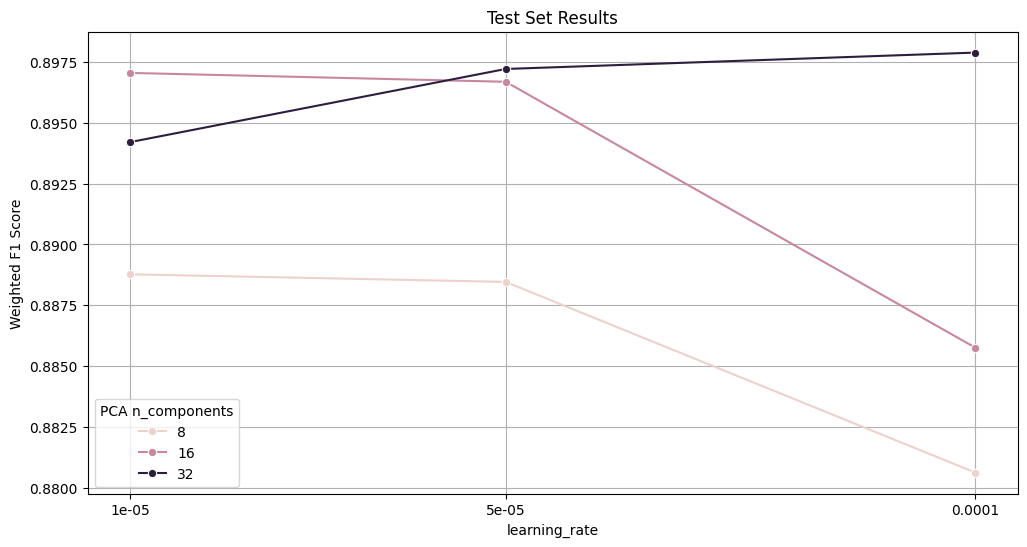

In [12]:
plot_results(df_testset, 'Test Set Results', 'learning_rate', 'weighted_f1', 'learning_rate', 'Weighted F1 Score')

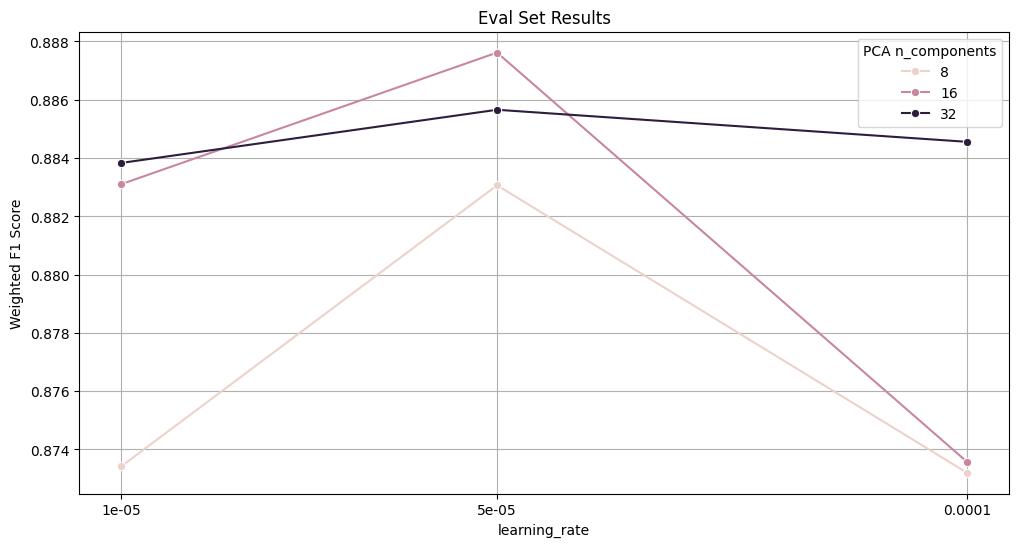

In [13]:
plot_results(df_evalset, 'Eval Set Results', 'learning_rate', 'weighted_f1', 'learning_rate', 'Weighted F1 Score')

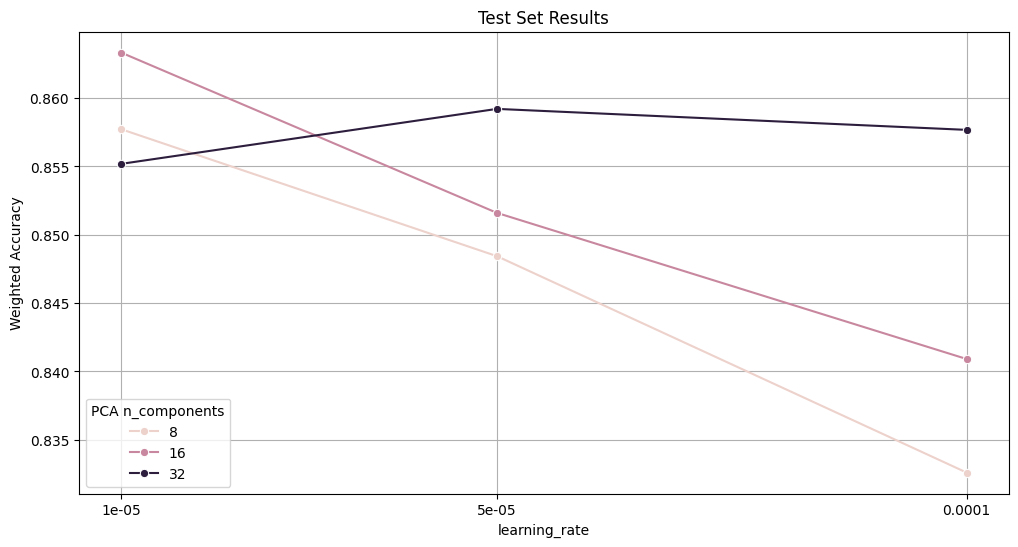

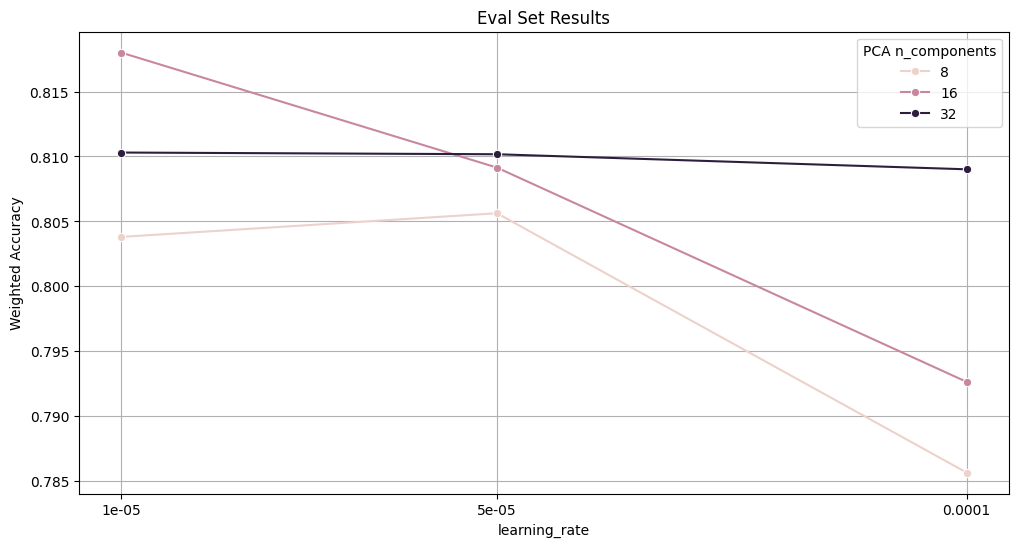

In [14]:
plot_results(df_testset, 'Test Set Results', 'learning_rate', 'weighted_acc', 'learning_rate', 'Weighted Accuracy')
plot_results(df_evalset, 'Eval Set Results', 'learning_rate', 'weighted_acc', 'learning_rate', 'Weighted Accuracy')

Select the best model and view its confusion matrix

In [15]:
best_model_eval = df_evalset.loc[df_evalset['weighted_f1'].idxmax()]
best_batch_size, best_learning_rate = int(best_model_eval['batch_size']), float(best_model_eval['learning_rate'])

model_dir = top_model_dir / f'bs_{best_batch_size}_lr_{best_learning_rate}'
if not model_dir.exists():
    raise FileNotFoundError(f"Directory {model_dir} does not exist.")

# load the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
y_test = np.load(model_dir / f'y_labels_test.npy')
y_pred_test = np.load(model_dir / f'y_pred_test.npy')
y_eval = np.load(model_dir / f'y_labels_valid.npy')
y_pred_eval = np.load(model_dir / f'y_pred_valid.npy')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Assuming you have a list of class names

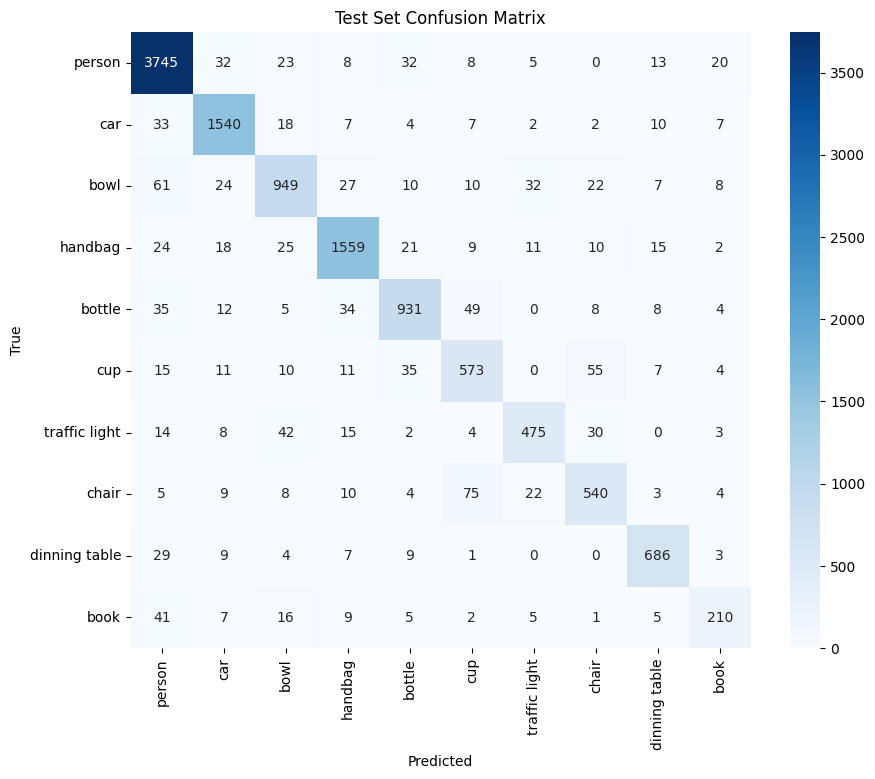

In [16]:
plot_confusion_matrix(y_test, y_pred_test, LABELS, 'Test Set Confusion Matrix')

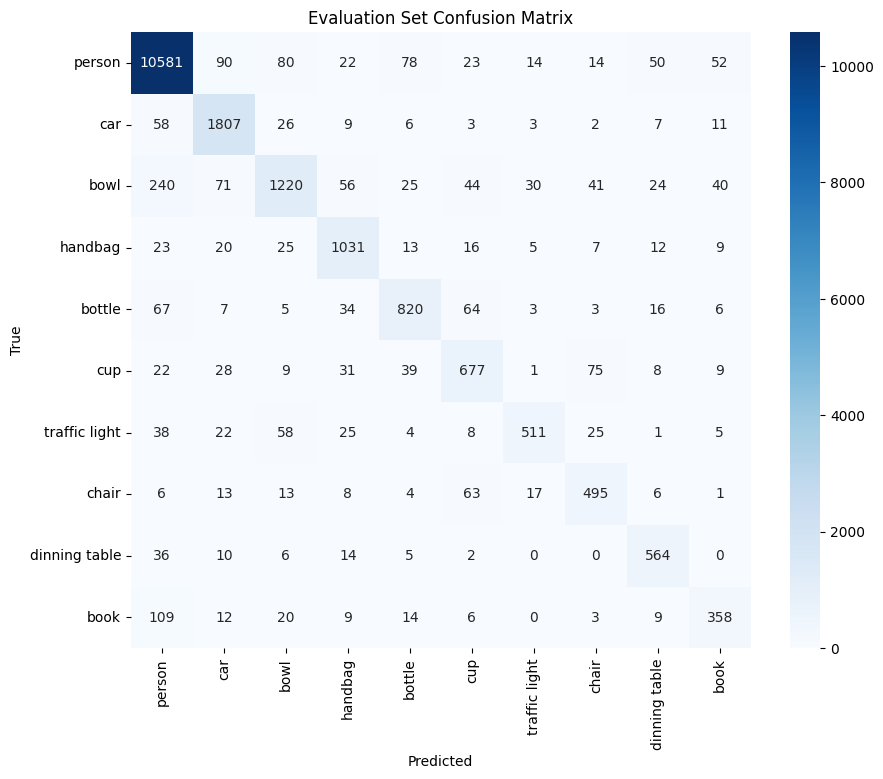

In [17]:
plot_confusion_matrix(y_eval, y_pred_eval, LABELS, 'Evaluation Set Confusion Matrix')